## Visualization of f-statistic distributions for selected features

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

### Load selected coefficients

In [2]:
results_dir = os.path.join('results', 'univariate_fs', 'pancancer')

In [3]:
# gene to analyze features for
gene = 'PIK3CA'

id_coefs_info = []
for identifier, coefs_list in au.generate_nonzero_coefficients_fs(
        results_dir, cfg.fs_methods):
    if not identifier.startswith(gene): continue
    for fold_no, coefs in enumerate(coefs_list):
        id_coefs_info.append([identifier, fold_no, coefs])
        
print(len(id_coefs_info))

40


In [4]:
# format of id_coefs_info:
# [experiment descriptor, fold no, [list of features and effect sizes]]
print(len(id_coefs_info[0]))
print(id_coefs_info[0][:2], id_coefs_info[0][2][:5])

3
['PIK3CA_mad_n1000', 0] [('5708', 0.15391), ('7037', 0.12557), ('1981', 0.12379), ('5476', -0.093147), ('5295', 0.09281)]


In [5]:
# list of sets, one for each feature selection method, of
# features that were selected in at least one cross-validation fold
fs_method_coefs = {}
for coefs_list in id_coefs_info:
    identifier = coefs_list[0]
    features = list(zip(*coefs_list[2]))[0]
    if identifier in fs_method_coefs:
        fs_method_coefs[identifier].update(features)
    else:
        fs_method_coefs[identifier] = set(features)
    
print(list(fs_method_coefs.keys()))

['PIK3CA_mad_n1000', 'PIK3CA_median_f_test_n100', 'PIK3CA_mad_n100', 'PIK3CA_mad_f_test_n100', 'PIK3CA_pancan_f_test_n100']


### Get distribution of univariate feature correlations

NOTE: these won't be exactly what was used for feature selection since we're not doing the same train/test splits here, or filtering cancer types by mutation count -- instead we're just calculating on the whole dataset. This could and probably should be fixed in the future, the actual distributions that we're selecting features based on could be quite different.

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif

import pancancer_evaluation.utilities.data_utilities as du

print('Loading gene label data...', file=sys.stderr)
genes_df = du.load_top_50()
sample_info_df = du.load_sample_info(verbose=True)

# this returns a tuple of dataframes, unpack it below
pancancer_data = du.load_pancancer_data(verbose=True)
(sample_freeze_df,
 mutation_df,
 copy_loss_df,
 copy_gain_df,
 mut_burden_df) = pancancer_data

rnaseq_df = du.load_expression_data(verbose=True)

Loading gene label data...
Loading sample info...
Loading pan-cancer data from cached pickle file...
Loading gene expression data...


In [7]:
print(rnaseq_df.shape)
rnaseq_df.iloc[:5, :5]

(11060, 16148)


,1,10,100,1000,10000
sample_id,,,,,
TCGA-02-0047-01,125.0,10.40,136.0,2300.0,1300.0
TCGA-02-0055-01,392.0,1.12,222.0,1820.0,903.0
TCGA-02-2483-01,272.0,4.64,256.0,2890.0,1320.0
TCGA-02-2485-01,83.9,20.00,129.0,6970.0,10100.0
TCGA-02-2486-01,108.0,3.66,205.0,2250.0,873.0


In [8]:
y_df = (mutation_df
    .loc[:, [gene]]
    .merge(sample_freeze_df, left_index=True, right_on='SAMPLE_BARCODE')
    .drop(columns='PATIENT_BARCODE')
    .set_index('SAMPLE_BARCODE')
    .rename(columns={gene: 'status',
                     'DISEASE': 'cancer_type',
                     'SUBTYPE': 'subtype'})
)
display(y_df.shape, y_df.head())

(9074, 3)

,status,cancer_type,subtype
SAMPLE_BARCODE,,,
TCGA-02-0047-01,1,GBM,IDHwt
TCGA-02-0055-01,0,GBM,IDHwt
TCGA-02-2483-01,0,GBM,IDHmut-non-codel
TCGA-02-2485-01,1,GBM,IDHwt
TCGA-02-2486-01,0,GBM,IDHwt


In [9]:
X_df_unscaled = rnaseq_df.reindex(y_df.index)

X_df = pd.DataFrame(
    StandardScaler().fit_transform(X_df_unscaled),
    index=X_df_unscaled.index.copy(),
    columns=X_df_unscaled.columns.copy()
)

# make sure we didn't introduce any NA rows
assert X_df.isna().sum().sum() == 0

display(X_df.shape,
        X_df.isna().sum().sum(),
        X_df.iloc[:5, :5])

(9074, 16148)

0

,1,10,100,1000,10000
SAMPLE_BARCODE,,,,,
TCGA-02-0047-01,-0.134350,-0.115823,-0.208325,1.022045,0.645482
TCGA-02-0055-01,-0.112881,-0.216739,-0.139308,0.683152,0.164651
TCGA-02-2483-01,-0.122530,-0.178461,-0.112022,1.438602,0.669705
TCGA-02-2485-01,-0.137654,-0.011428,-0.213943,4.319199,11.303693
TCGA-02-2486-01,-0.135717,-0.189118,-0.152951,0.986744,0.128316


In [10]:
def filter_cancer_types(gene, X_df, y_df, sample_freeze_df, mutation_burden_df):
    # most of this code is copied from process_y_matrix in pancancer_utilities.tcga_utilities
    # 
    # note this is not including copy number variants, to do that we have to
    # know oncogene/TSG status for every gene (need to figure out where to get
    # this info)
    y_df = (
        y_df.merge(
            sample_freeze_df,
            how='left',
            left_index=True,
            right_on='SAMPLE_BARCODE'
        )
        .set_index('SAMPLE_BARCODE')
        .merge(mutation_burden_df, left_index=True, right_index=True)
    )
    disease_counts_df = pd.DataFrame(y_df.groupby('cancer_type').sum()['status'])
    disease_proportion_df = disease_counts_df.divide(
        y_df['cancer_type'].value_counts(sort=False).sort_index(), axis=0
    )
    filter_disease_df = (
        (disease_counts_df > cfg.filter_count) &
        (disease_proportion_df > cfg.filter_prop)
    )
    disease_proportion_df['disease_included'] = filter_disease_df
    disease_proportion_df['count'] = disease_counts_df['status']
    filter_disease_df.columns = ['disease_included']
    
    use_diseases = disease_proportion_df.query('disease_included').index.tolist()
    
    y_filtered_df = y_df.query('cancer_type in @use_diseases')
    X_filtered_df = X_df.reindex(index=y_filtered_df.index)
    
    return X_filtered_df, y_filtered_df

def get_f_stats_for_cancer_types(gene, X_df, y_df):
    # filter to cancer types with sufficient mutations
    X_filtered_df, y_filtered_df = filter_cancer_types(
        gene, X_df, y_df, sample_freeze_df, mut_burden_df
    )
    assert X_filtered_df.isna().sum().sum() == 0
    
    # then calculate pan-cancer and specific-cancer f-statistics
    # (i.e. univariate correlations with labels)
    f_stats_df = {
        'pancan': f_classif(X_filtered_df, y_filtered_df.status)[0]
    }
    for cancer_type in y_filtered_df.cancer_type.unique():
        ct_samples = y_filtered_df[y_filtered_df.cancer_type == cancer_type].index
        X_ct_df = X_filtered_df.reindex(ct_samples)
        y_ct_df = y_filtered_df.reindex(ct_samples)
        
        f_stats_df[cancer_type] = f_classif(X_ct_df, y_ct_df.status)[0]
        
    return pd.DataFrame(f_stats_df, index=X_filtered_df.columns)

In [11]:
f_stats_df = get_f_stats_for_cancer_types(gene, X_df, y_df)
f_stats_df.iloc[:5, :5]

,pancan,LUAD,LUSC,UCEC,BLCA
1,0.031255,2.113628,0.638567,0.178490,0.015433
10,17.405591,0.356228,0.002447,0.984434,1.004380
100,9.863254,7.109284,1.824715,2.376647,0.000861
1000,16.596111,0.341211,0.081557,0.236087,2.729152
10000,117.966471,0.000046,3.303869,0.203793,6.404321


In [12]:
f_stats = {}

for fs_method, genes in fs_method_coefs.items():
    X_selected_df = X_df.loc[:, X_df.columns.intersection(genes)]
    f_stats_df = get_f_stats_for_cancer_types(gene, X_selected_df, y_df)
    f_stats[fs_method] = f_stats_df
    
fs_1 = list(fs_method_coefs.keys())[0]
display(fs_1, f_stats[fs_1].iloc[:5, :5])

'PIK3CA_mad_n1000'

,pancan,LUAD,LUSC,UCEC,BLCA
1001,3.308429,9.322984,0.538218,0.182691,0.122666
100133941,24.404035,0.575575,2.869598,0.320244,0.466735
10057,3.144996,17.963213,0.063306,5.973185,3.113879
10075,6.751117,1.462026,0.218674,0.140938,0.980724
10079,14.325298,1.807782,0.025135,0.205491,0.406995


PIK3CA_mad_n1000 (14210,)
PIK3CA_median_f_test_n100 (4032,)
PIK3CA_mad_n100 (1428,)
PIK3CA_mad_f_test_n100 (3640,)
PIK3CA_pancan_f_test_n100 (2072,)


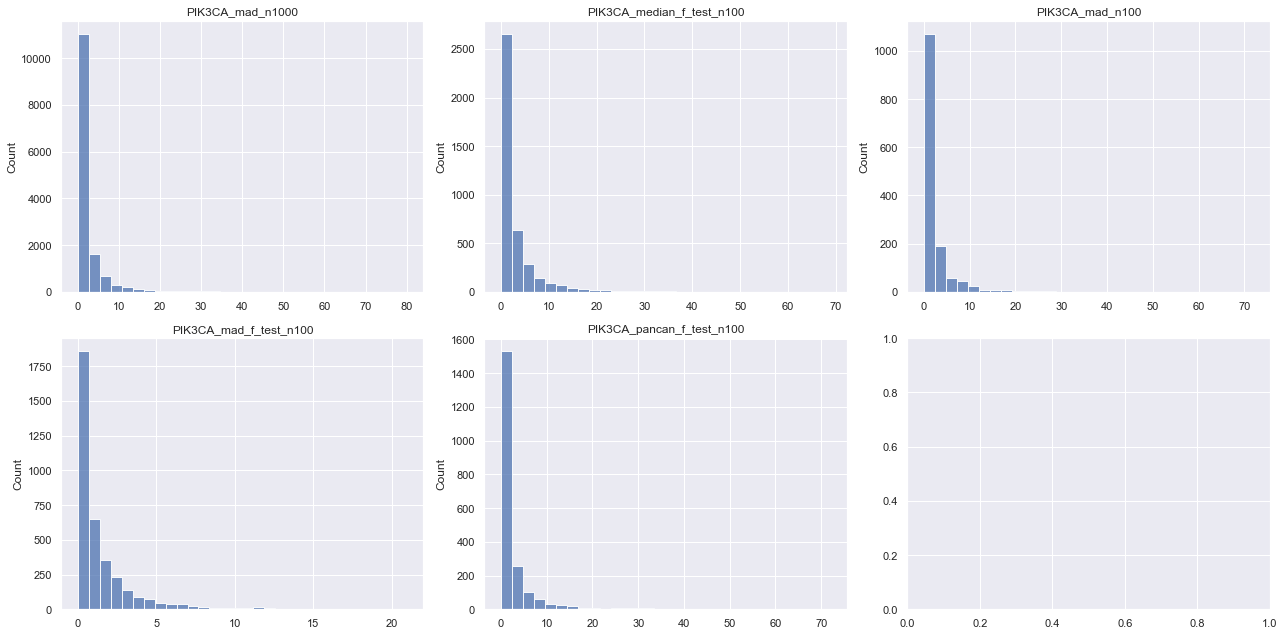

In [13]:
sns.set({'figure.figsize': (18, 9)})
sns.set_context('notebook')

fig, axarr = plt.subplots(2, 3)

for ix, (fs_method, f_stats_df) in enumerate(f_stats.items()):
    ax = axarr[ix // 3, ix % 3]
    dist_vals = (f_stats_df
        .loc[:, ~(f_stats_df.columns == 'pancan')]
        .values
        .flatten()
    )
    print(fs_method, dist_vals.shape)
    sns.histplot(dist_vals, ax=ax, bins=30)
    ax.set_title(fs_method)
    
plt.tight_layout()

In [14]:
# top 6 median f-test values
f_df = f_stats['{}_median_f_test_n100'.format(gene)]
median_df = (f_df
    .loc[:, ~(f_df.columns == 'pancan')]
    .median(axis='columns')
    .sort_values(ascending=False)
)
median_df.iloc[:5]

5295      4.668344
5226      3.335784
222166    3.069949
10057     3.035525
284119    2.975707
dtype: float64

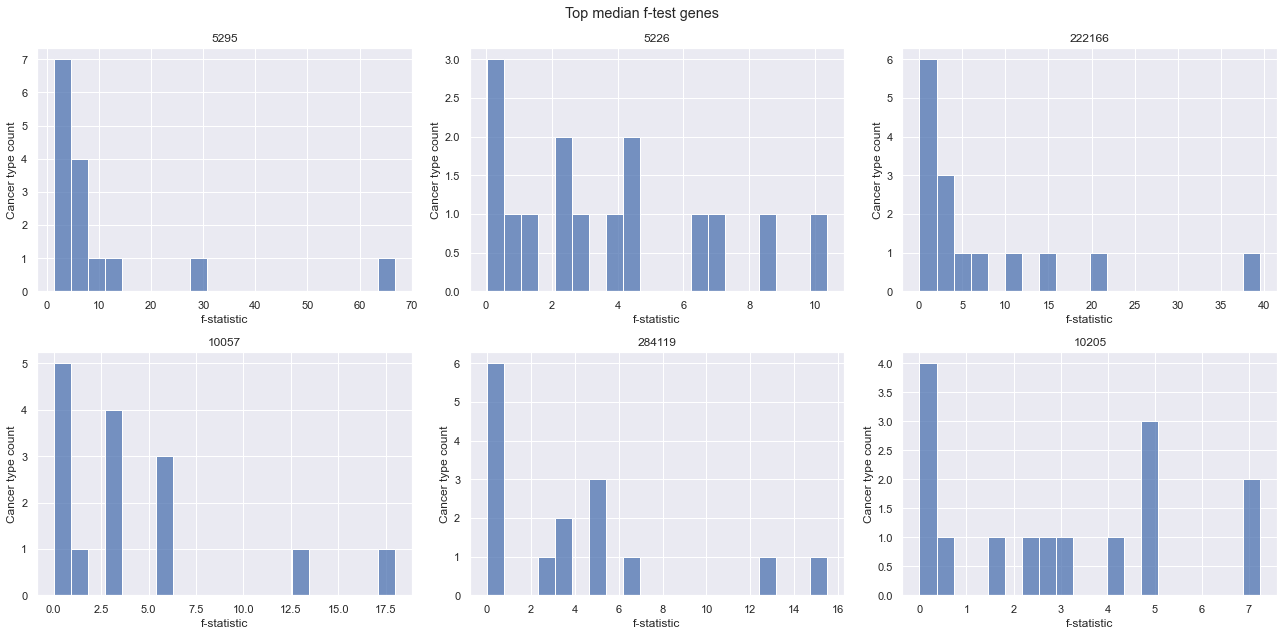

In [15]:
sns.set({'figure.figsize': (18, 9)})
sns.set_context('notebook')

fig, axarr = plt.subplots(2, 3)

genes_to_plot = median_df.index[:6]
for ix, gene_to_plot in enumerate(genes_to_plot):
    ax = axarr[ix // 3, ix % 3]
    dist_df = f_df.loc[gene_to_plot, :]
    sns.histplot(dist_df.values, ax=ax, bins=20)
    ax.set_title(gene_to_plot)
    ax.set_xlabel('f-statistic')
    ax.set_ylabel('Cancer type count')
    
plt.suptitle('Top median f-test genes')
plt.tight_layout()

In [16]:
# top 6 pan-cancer f-test values
f_df = f_stats['{}_pancan_f_test_n100'.format(gene)]
pancan_df = (f_df
    .loc[:, 'pancan']
    .sort_values(ascending=False)
)
pancan_df.iloc[:5]

57535    213.276034
5757     191.605745
3020     190.947790
2099     164.170274
30061    160.692191
Name: pancan, dtype: float64

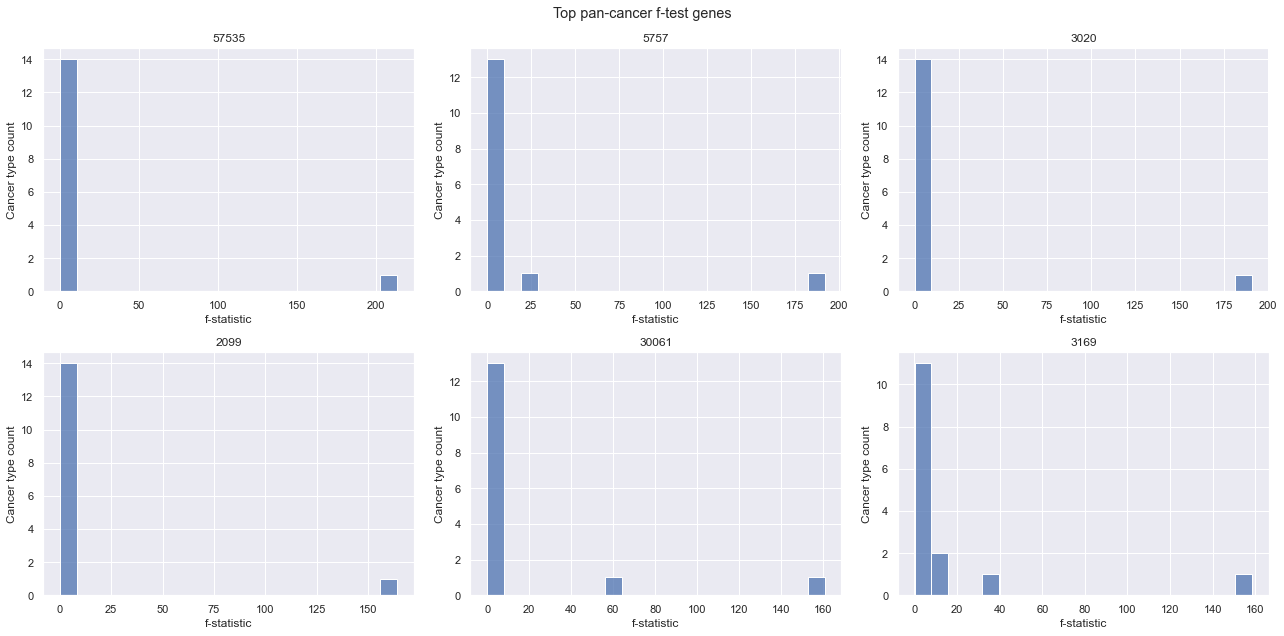

In [17]:
sns.set({'figure.figsize': (18, 9)})
sns.set_context('notebook')

fig, axarr = plt.subplots(2, 3)

genes_to_plot = pancan_df.index[:6]
for ix, gene_to_plot in enumerate(genes_to_plot):
    ax = axarr[ix // 3, ix % 3]
    dist_df = f_df.loc[gene_to_plot, :]
    sns.histplot(dist_df.values, ax=ax, bins=20)
    ax.set_title(gene_to_plot)
    ax.set_xlabel('f-statistic')
    ax.set_ylabel('Cancer type count')
    
plt.suptitle('Top pan-cancer f-test genes')
plt.tight_layout()

In [18]:
# top 6 MAD genes
f_df = f_stats['{}_mad_n100'.format(gene)]
X_filtered_df, y_filtered_df = filter_cancer_types(
    gene, X_df, y_df, sample_freeze_df, mut_burden_df
)
mad_df = (X_filtered_df
    .loc[:, (X_filtered_df.columns.isin(fs_method_coefs['{}_mad_n100'.format(gene)]))]
    .mad(axis='index')
    .sort_values(ascending=False)
)
mad_df.iloc[:5]

3856     0.764611
79026    0.731883
7494     0.728451
7534     0.719473
5660     0.717954
dtype: float64

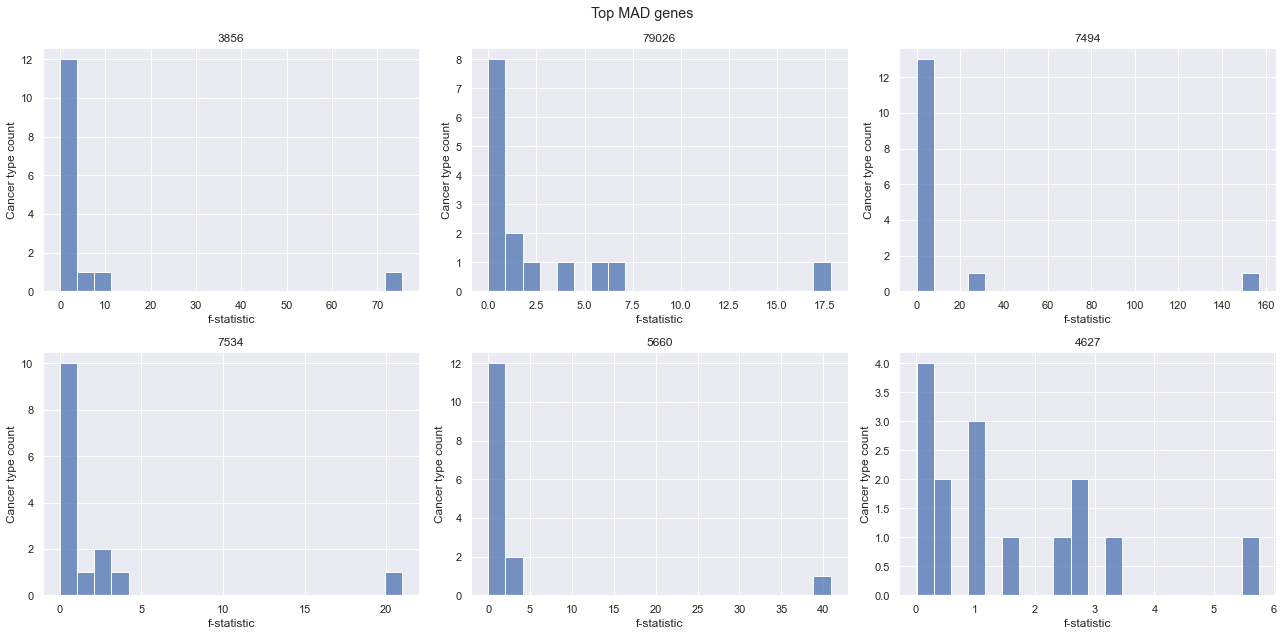

In [19]:
sns.set({'figure.figsize': (18, 9)})
sns.set_context('notebook')

fig, axarr = plt.subplots(2, 3)

genes_to_plot = mad_df.index[:6]
for ix, gene_to_plot in enumerate(genes_to_plot):
    ax = axarr[ix // 3, ix % 3]
    dist_df = f_df.loc[gene_to_plot, :]
    sns.histplot(dist_df.values, ax=ax, bins=20)
    ax.set_title(gene_to_plot)
    ax.set_xlabel('f-statistic')
    ax.set_ylabel('Cancer type count')
    
plt.suptitle('Top MAD genes')
plt.tight_layout()